In [45]:
import torch
import h5py
import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path
from omegaconf import OmegaConf
from matplotlib import cm, colors
from matplotlib.axes import Axes
from matplotlib.lines import Line2D

In [46]:
def plot_M_thin_film2(
    m: np.ndarray,
    res: list[int],
    ax: plt.Axes,
    title: str | None = None,
    scale: float | None = None,
    width: float = 0.002,
    headwidth: float = 3,
    headlength: float = 5,
) -> None:
    '''
    Rework of plot_M_thin_film from magtense.utils to support subplots
    '''
    m = np.permute_dims(m, (1, 2, 0))  # CHW -> HWC
    k = np.moveaxis(m.reshape(res[1], res[0], res[2], 3).swapaxes(0, 1), -1, 0)[
        :, :, :, 0
    ]

    ax.clear()
    ax.quiver(
        k[0].T + 1e-20,
        k[1].T + 1e-20,
        pivot="mid",
        scale=scale,
        width=width,
        headwidth=headwidth,
        headlength=headlength,
    )

    nz = colors.Normalize(0.0, 2 * np.pi)
    clr = np.swapaxes(cm.hsv(nz(np.arctan2(k[1], k[0]) + np.pi)), 0, 1)
    ax.imshow(clr, interpolation="bicubic")

    ax.axis("scaled")
    #ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    if title:
        ax.set_title(title)

In [3]:
root_dir = dpde.utils.get_repo_root()
data_dir = root_dir / "data" 

In [4]:
REFORMAT_DATABASE = False

if REFORMAT_DATABASE:
    data_path = data_dir / "llg_temp" / "200_150_64_16.h5"

    with h5py.File(data_path, "r") as f:
        field = f["field"][:]
        sequence = f["sequence"][:]
        attrs = dict(f.attrs)
    attrs["num_t_steps"] = attrs.pop("t_steps")
    [print(f"  {k}: {v}") for k, v in attrs.items()];
    sequence = np.permute_dims(sequence, (0, 4, 2, 3, 1))

    T = attrs["t_per_step"] * (attrs["num_t_steps"] - 1)
    t_steps = np.arange(attrs["num_t_steps"]) * attrs["t_per_step"]
    print(f"Total simulation time: {T:.3e} s")
    assert T == t_steps[-1]

    dx = attrs["grid_size"][0] / (attrs["res"][0] - 1)
    dy = attrs["grid_size"][1] / (attrs["res"][1] - 1)
    print(f"Grid spacing: dx = {dx:.3e} m, dy = {dy:.3e} m")

    A = sequence[..., 0]
    U = sequence[:]
    labels = field[:]

    save_path = data_dir / "llg_validate.hdf5"
    dpde.pdes.utils.save_data(
        str(save_path),
        A=A,
        U=U,
        labels=labels,
        t_steps=t_steps,
        T=T,
        dx=dx,
        dy=dy,
        **attrs
    )
else:
    save_path = data_dir / "llg_validate.hdf5"

In [5]:
with h5py.File(save_path, "r") as f:
    A = f["A"][:]
    U = f["U"][:]
    labels = f["labels"][:]
    t_steps = f["t_steps"][:]
    attrs = dict(f.attrs)
print(f"A shape: {A.shape}, U shape: {U.shape}, labels shape: {labels.shape}")
[print(f"  {k}: {v}") for k, v in attrs.items()];

A shape: (200, 3, 64, 16), U shape: (200, 3, 64, 16, 150), labels shape: (200, 3)
  N: 200
  T: 2.235e-09
  dx: 7.936507936507936e-09
  dy: 8.333333333333334e-09
  grid_size: [5.00e-07 1.25e-07 3.00e-09]
  h_ext_angle: [  0 360]
  h_ext_norm: [ 0 50]
  num_t_steps: 150
  res: [64 16  1]
  seed: 42
  t_per_step: 1.5e-11


In [6]:
dx = attrs["dx"]
dy = attrs["dy"]
T = attrs["T"]
res = attrs["res"]
grid_size = attrs["grid_size"]

In [11]:
model_path = Path("/home/s204790/dynamical-pde-diffusion/pretrained_models/llg_llg_unet_v2.pth")
cfg_path = Path("/home/s204790/dynamical-pde-diffusion/logs/hydra/2025-11-11_12-40-13/.hydra/config.yaml")
cfg = OmegaConf.load(cfg_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

edm = dpde.utils.get_net_from_config(cfg)
edm.to(device)

edm.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [29]:
idx = 0   # which sample to visualize
t_idx = 20  # which time step to visualize

t = t_steps[t_idx].item()
lbl = labels[idx, :]
a = A[idx, :]  # (S, S)
u = U[idx, :, :, :, t_idx]  # (S, S)

a.shape, u.shape

((3, 64, 16), (3, 64, 16))

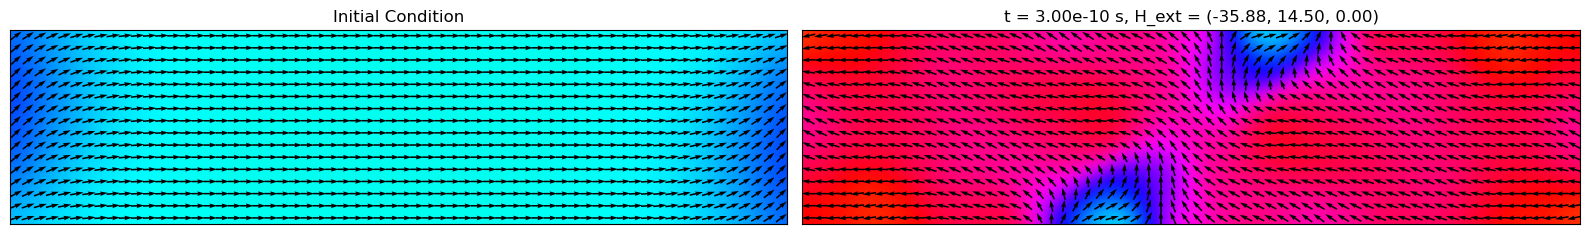

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_M_thin_film2(a, res=res, ax=axs[0], title="Initial Condition")
plot_M_thin_film2(u, res=res, ax=axs[1], title=f"t = {t:.2e} s, H_ext = ({", ".join([f'{h:.2f}' for h in lbl])})")
plt.tight_layout()
plt.show()

In [115]:
sample_shape = cfg.dataset.sampling.sample_shape
generator = torch.Generator().manual_seed(0)

interior_a = 1.0
boundary_a = 1.0

interior_u = 0.0
boundary_u = 0.0

boundary_obs_a = dpde.validation.random_boundary_mask(sample_shape[1], sample_shape[2], frac_obs=boundary_a)
interior_obs_a = dpde.validation.random_interior_mask(sample_shape[1], sample_shape[2], frac_obs=interior_a)

boundary_obs_u = dpde.validation.random_boundary_mask(sample_shape[1], sample_shape[2], frac_obs=boundary_u)
interior_obs_u = dpde.validation.random_interior_mask(sample_shape[1], sample_shape[2], frac_obs=interior_u)

mask_a = dpde.validation.combine_masks(boundary_obs_a, interior_obs_a)
mask_u = dpde.validation.combine_masks(boundary_obs_u, interior_obs_u)

In [116]:
def llg_loss(x, dxdt, obs_a, obs_u, mask_a, mask_u, dx, dy, ch_a, labels):
    """
    x:     (B, 6, H, W) = [a(=initial m), u(=current m)] channel-first, where each is 3 channels
    dxdt:  time-derivative predicted by your model, same shape as x
    labels: external field H_ext per sample, shape (B, 3) in A/m (recommend)
    """
    # ---- Constants (edit to your units) ----
    gamma0 = 2.211e5            # gyromagnetic ratio [m/(A·s)] (γ0)
    mu0    = 4 * torch.pi * 1e-7  # vacuum permeability [T·m/A]
    alpha  = 0.02                # damping

    # If your H_ext is in A/m (micromagnetics standard), use gamma = γ0 * μ0
    # If your H_ext is already in Tesla, set gamma = γ0
    gamma = gamma0 * mu0        # <-- change to gamma0 if labels are B (Tesla) rather than H (A/m)
    # Optional (set to non-None if you want exchange)
    A_ex = None #1.3e-11 #None    # [J/m]
    M_s  = None #8.05e5 #None    # [A/m]

    eps = 1e-12

    B, _, H, W = x.shape

    # Split inputs
    a = x[:, :ch_a, :, :]            # (B,3,H,W) initial magnetization (used only for obs loss)
    u = x[:, ch_a:, :, :]      # (B,3,H,W) magnetization m
    dm_dt = dxdt[:, ch_a:, :, :]

    # Enforce/encourage |m|=1 (LLG preserves |m|); renormalize softly to stabilize residuals
    m_norm = torch.clamp(u.norm(dim=1, keepdim=True), min=eps)
    m = u / m_norm

    # External field H_ext broadcast: (B,3,1,1)
    H_ext = labels.view(B, 3, 1, 1)

    # ---- Effective field H_eff ----
    H_eff = H_ext.clone()

    # Optional exchange: H_ex = (2 A_ex / (μ0 M_s)) ∇^2 m
    # Finite-difference 5-point Laplacian with Neumann (replicate) padding
    if (A_ex is not None) and (M_s is not None):
        lap = (
            -4.0 * m
            + F.pad(m, (1,1,0,0), mode="replicate")[:, :, :, 0:W]   # left
            + F.pad(m, (0,0,1,1), mode="replicate")[:, :, 0:H, :]   # up
            + F.pad(m, (1,1,0,0), mode="replicate")[:, :, :, 2:W+2] # right
            + F.pad(m, (0,0,1,1), mode="replicate")[:, :, 2:H+2, :] # down
        )
        lap /= (dx*dx + dy*dy)  # crude isotropic scaling; for anisotropic grids, use dx^2 & dy^2 separately
        H_ex = (2.0 * A_ex / (mu0 * M_s)) * lap
        H_eff = H_eff + H_ex

    # ---- LLG right-hand side (Gilbert form rearranged) ----
    # ∂m/∂t = -γ/(1+α^2) [ m × H_eff + α m × (m × H_eff) ]
    mxH = torch.cross(m, H_eff, dim=1)
    m_cross_mxH = torch.cross(m, mxH, dim=1)
    llg_rhs = -(gamma / (1.0 + alpha**2)) * (mxH + alpha * m_cross_mxH)

    # PDE residual
    resid = dm_dt - llg_rhs

    # ---- Losses ----
    # PDE loss: MSE over space & channels
    loss_pde = (resid ** 2).mean()

    # Add a small penalty to keep |m| close to 1 (helps training stability in practice)
    loss_unit = ((m.norm(dim=1) - 1.0) ** 2).mean()
    loss_pde = loss_pde + 1e-3 * loss_unit

    # Observation losses (masked MSEs). Normalize by number of observed elements.
    def masked_mse(pred, target, mask):
        num = (mask > 0).float().sum()
        if num < 0.5:  # nothing observed
            return torch.zeros((), device=pred.device, dtype=pred.dtype)
        return ((mask * (pred - target)) ** 2).sum() / (num + eps)

    loss_obs_a = masked_mse(a, obs_a, mask_a)
    loss_obs_u = masked_mse(m, obs_u, mask_u)  # use normalized m for obs consistency

    return loss_pde, loss_obs_a, loss_obs_u


In [117]:
def edm_sampler(
    net,            # EDMWrapper (calls Unet inside)
    device,         # device to run the sampler on  
    sample_shape,   # (B, C, H, W) shape of samples
    loss_fn,        # loss function to compute gradients
    loss_fn_kwargs, # extra args to pass to loss function
    labels,         # (B, label_dim) extra conditioning your Unet expects; use zeros if None
    zeta_a=1.0,     # weight for obs_a loss
    zeta_u=1.0,     # weight for obs_u loss
    zeta_pde=1.0,   # weight for pde loss
    num_steps=18,
    sigma_min=0.002,
    sigma_max=80.0,
    rho=7.0,
    S_churn=0.0,
    S_min=0.0,
    S_max=float('inf'),
    S_noise=1.0,
    to_cpu=True,
    generator=None,
    debug=False,
    return_losses=False,
    compile_net=False,
):
    dtype_f = torch.float32     # net runs in fp32
    dtype_t = torch.float64     # keep time grid in fp64 for stability, as in EDM

    B = sample_shape[0]
    
    net.to(device=device)

    if compile_net:
        net = torch.compile(net)
        
    labels = labels.to(device=device, dtype=dtype_f)    # move labels to correct device and dtype

    if generator is None:
        generator = torch.Generator(device=device)

    # Initial sample at sigma_max
    latents = torch.randn(sample_shape, device=device, generator=generator)
    
    # Move loss function kwargs to correct device and dtype
    for key, val in loss_fn_kwargs.items():
        if isinstance(val, torch.Tensor):
            loss_fn_kwargs[key] = val.to(device=device, dtype=dtype_t)

    # Discretize sigmas per EDM (Karras et al. 2022), t_N = 0 appended.
    step_idx = torch.arange(num_steps, dtype=dtype_t, device=device)
    sigmas = (sigma_max**(1.0/rho) + step_idx/(num_steps-1) * (sigma_min**(1.0/rho) - sigma_max**(1.0/rho)))**rho
    sigmas = getattr(net, "round_sigma", lambda x: x)(sigmas)
    sigmas = torch.cat([sigmas, torch.zeros_like(sigmas[:1])])  # length N+1, last = 0

    # Initialize x at sigma_0
    x_next = (latents.to(dtype_t) * sigmas[0])

    losses = torch.zeros((num_steps, 4), device=device)  # for debugging
    
    for i, (sigma_cur, sigma_next) in enumerate(zip(sigmas[:-1], sigmas[1:])):  # i = 0..N-1
        x_cur = x_next.detach().clone()
        x_cur.requires_grad = True

        # Stochastic "churn" (optional)
        gamma = (min(S_churn / num_steps, (2.0**0.5) - 1.0)
                 if (sigma_cur >= S_min and sigma_cur <= S_max) else 0.0)
        sigma_hat = getattr(net, "round_sigma", lambda x: x)(sigma_cur + gamma * sigma_cur)

        # Add noise to increase sigma from sigma_cur to sigma_hat
        noise_scale = torch.sqrt(sigma_hat**2 - sigma_cur**2)
        x_hat = x_cur + (noise_scale * S_noise) * torch.randn_like(x_cur)

        # Euler step to t_next
        x_N, dxdt = dpde.sampling.X_and_dXdt_fd(net, x_hat.to(dtype_f), torch.full((B,), sigma_hat, device=device, dtype=dtype_f), labels)
        x_N, dxdt = x_N.to(dtype_t), dxdt.to(dtype_t)
        d_cur = (x_hat - x_N) / sigma_hat
        x_next = x_hat + (sigma_next - sigma_hat) * d_cur

        # Heun (2nd-order) correction unless final step
        if i < num_steps - 1:
            x_N, dxdt = dpde.sampling.X_and_dXdt_fd(net, x_next.to(dtype_f), torch.full((B,), sigma_next, device=device, dtype=dtype_f), labels)
            x_N, dxdt = x_N.to(dtype_t), dxdt.to(dtype_t)
            d_prime = (x_next - x_N) / sigma_next
            x_next = x_hat + (sigma_next - sigma_hat) * (0.5 * d_cur + 0.5 * d_prime)

        # Compute losses
        loss_pde, loss_obs_a, loss_obs_u = loss_fn(x_N, dxdt, **loss_fn_kwargs)

        if i <= 0.8 * num_steps:
            w_a, w_u, w_pde = zeta_a, zeta_u, zeta_pde
        else:
            w_a, w_u, w_pde = 0.1 * zeta_a, 0.1 * zeta_u, zeta_pde

        loss_comb = w_a * loss_obs_a + w_u * loss_obs_u + w_pde * loss_pde
        grad_x = torch.autograd.grad(loss_comb, x_cur, retain_graph=False)[0]
        x_next = x_next - grad_x
        

        losses[i] = torch.stack([loss_obs_a, loss_obs_u, loss_pde, loss_comb])
  
    # Return at sigma=0 in fp32
    x = x_next.to(dtype_f).detach()
    if to_cpu:
        x = x.cpu()

    losses = losses.detach().cpu().numpy() if return_losses else None

    return x, losses

In [118]:
obs_a = torch.tensor(a)
obs_u = torch.tensor(u)

ch_a = 3

sample_shape = (32, 6, 64, 16)

zeta_a = 20.0
zeta_u = 20.0
zeta_pde = 2.5

num_steps = 50

t_cond = torch.full((sample_shape[0], 1), t)
h_ext = torch.tensor(lbl).unsqueeze(0).repeat(sample_shape[0], 1)
lbls = torch.cat([t_cond, h_ext], dim=-1)

lbls.shape

loss_fn_kwargs = {
    "obs_a": obs_a,
    "obs_u": obs_u,
    "mask_a": mask_a,
    "mask_u": mask_u,
    "dx": dx,
    "dy": dx,
    "ch_a": ch_a,
    "labels": h_ext,
}

torch.backends.cudnn.conv.fp32_precision = 'tf32'

#for i in range(10):
samples, losses = dpde.sampling.edm_sampler(
    net=edm,
    device=device,
    sample_shape=sample_shape,
    loss_fn=llg_loss,
    loss_fn_kwargs=loss_fn_kwargs,
    labels=lbls,
    zeta_a=zeta_a,
    zeta_u=zeta_u,
    zeta_pde=zeta_pde,
    num_steps=num_steps,
    to_cpu=True,
    debug=True,
    return_losses=True,
    compile_net=False,
)
print(f"Final total loss: {losses[-1, 3]:.4f}")
samples = samples.numpy()

Final total loss: 14.5807


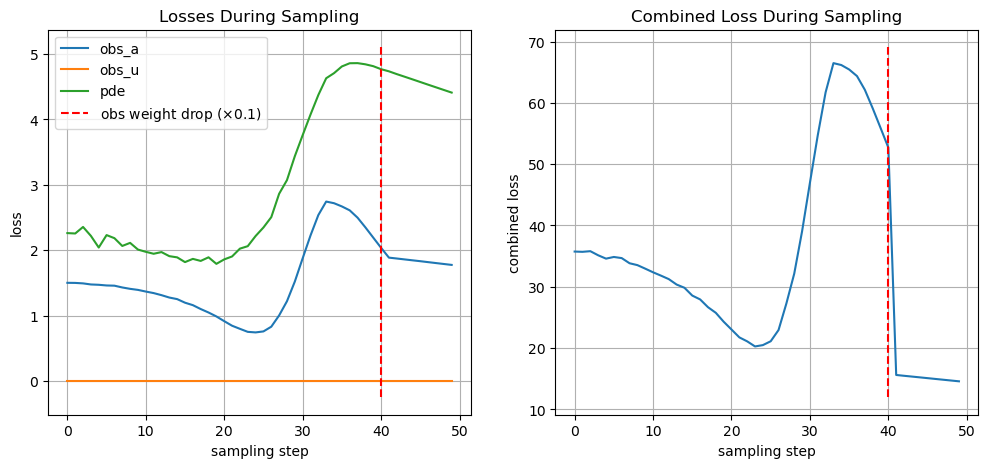

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :3])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, 3])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(['obs_a', 'obs_u', 'pde', 'obs weight drop ($\\times 0.1$)'])
plt.show()

In [120]:
rng = np.random.default_rng()

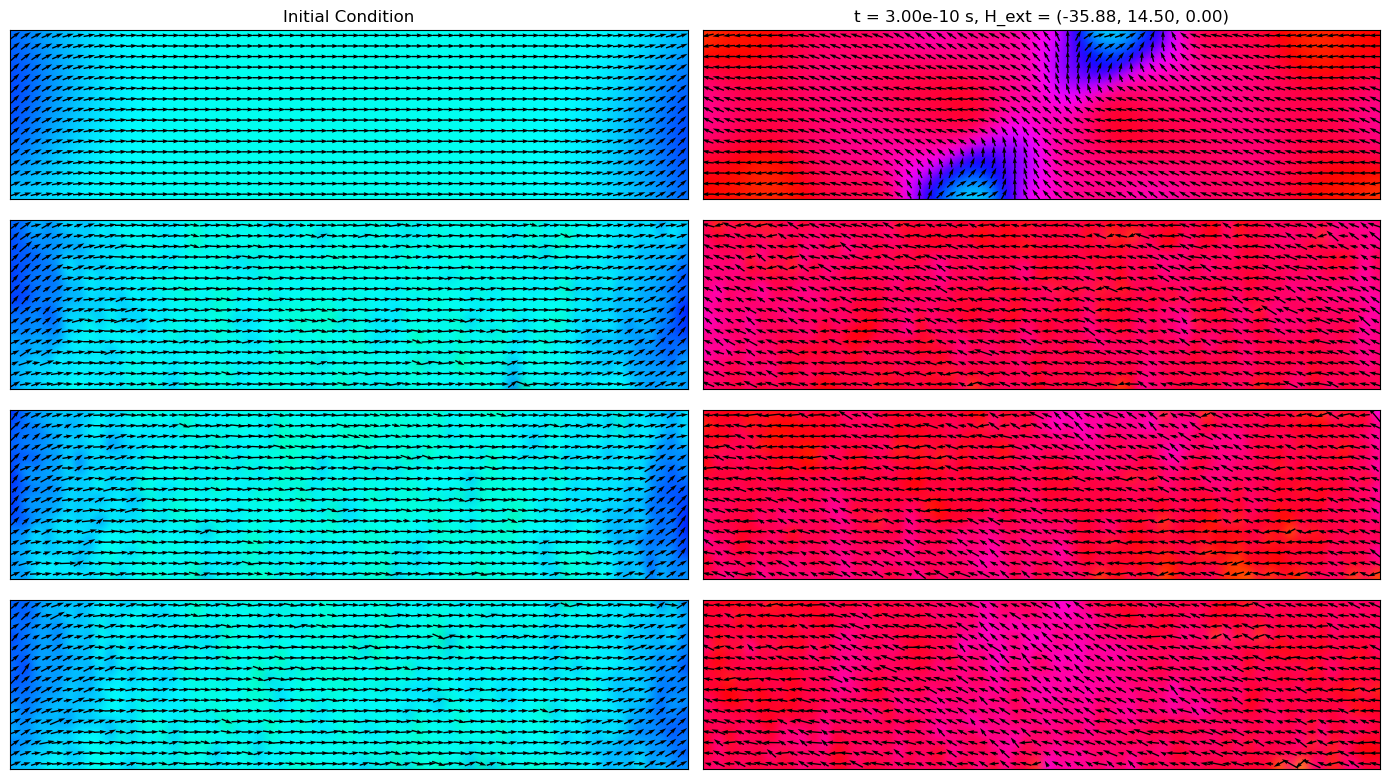

In [121]:
num_samples_plot = 3
fig, axs = plt.subplots(num_samples_plot + 1, 2, figsize=(14, 2 * (num_samples_plot + 1)))

plot_M_thin_film2(a, res=res, ax=axs[0, 0], title="Initial Condition")
plot_M_thin_film2(u, res=res, ax=axs[0, 1], title=f"t = {t:.2e} s, H_ext = ({", ".join([f'{h:.2f}' for h in lbl])})")
for i in range(num_samples_plot):
    idx = rng.integers(0, samples.shape[0])
    plot_M_thin_film2(samples[idx, :ch_a, ...], res=res, ax=axs[i + 1, 0])
    plot_M_thin_film2(samples[idx, ch_a:, ...], res=res, ax=axs[i + 1, 1])
plt.tight_layout()
plt.show()

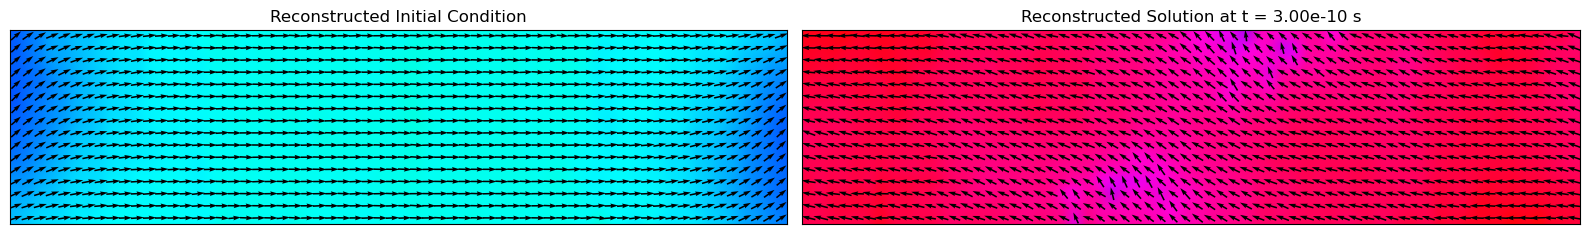

In [114]:
average_a = samples[:, :ch_a, ...].mean(axis=0)
average_u = samples[:, ch_a:, ...].mean(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_M_thin_film2(average_a, res=res, ax=axs[0], title="Reconstructed Initial Condition")
plot_M_thin_film2(average_u, res=res, ax=axs[1], title=f"Reconstructed Solution at t = {t:.2e} s")
plt.tight_layout()
plt.show()

In [41]:
samples.shape

(32, 6, 64, 16)

In [42]:
std_u = samples[:, ch_a:, ...].std(axis=(0, 1))

In [43]:
std_u.shape

(64, 16)

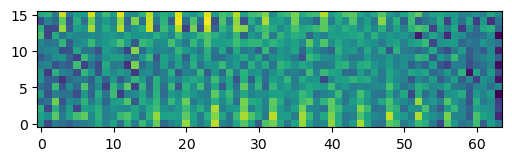

In [44]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(std_u.T, cmap='viridis', origin='lower')